In [63]:
%matplotlib notebook
%matplotlib inline

import os
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})


# Below plots are based on Tensorboard logs (not based on every iteration)

## Uncomment this in case csv files are not available

In [ ]:
# experiment_id, experiment_name = "6yl48QRjSySDUpTg8TpeRw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_29d20f8"
# experiment_id, experiment_name = "zNo4qyA5RBybC9m0sPRiZw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_b4f39ae"
# experiment_id, experiment_name = "7M4Qi6dmQteoRpuOibFbWQ", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
# experiment_id, experiment_name = "xsV7RvysQkyiriyOKoTJ6A", "iou_metrics_st_bs8_split_1_1_trial_1_ca74a38"
# experiment_id, experiment_name = "o7fRMElwRAKv6boGQb29FQ", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"
# experiment_id, experiment_name = "EAX8ewgYSQODg2LyOi9n2g", "a8_plot_0cf4067"
# experiment_id, experiment_name = "mJAdmSVVSZG3M2lpoigMUg", "best_st_plot_0cf4067"


# experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
# df = experiment.get_scalars()
# df.to_csv(f"metrics_{experiment_name}.csv", index=False)

# df = pd.read_csv(f"metrics_{experiment_name}.csv")

## (Fig 6) Plot TP/FP/FN weights 

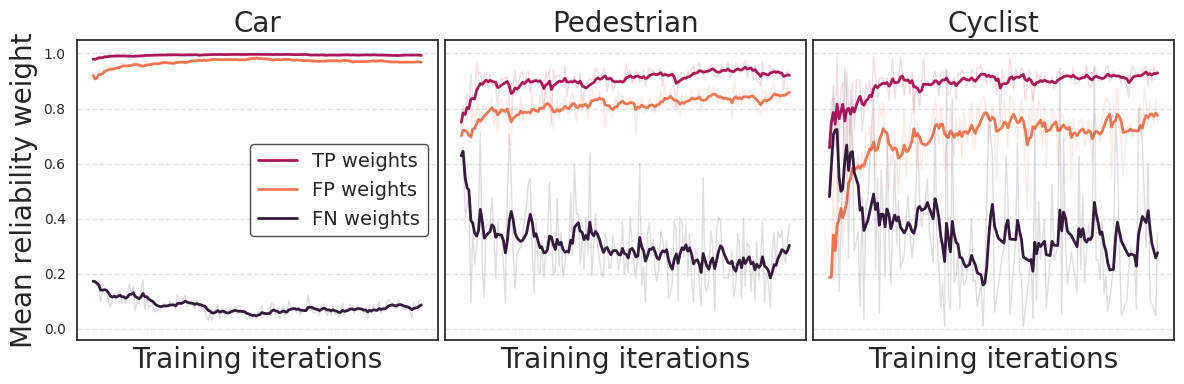

In [55]:
def draw_tp_fp_fn_weight_plot(df, fname, tags=None, tag_names=None, threshs=None, y_label=None):
    f, axes = plt.subplots(1, 3, sharey=True, figsize=(12,4))
    base_run = "tensorboard"
    classes = ["Car", "Pedestrian", "Cyclist"]
    p = sns.color_palette('rocket_r')
    palette = [p[3], p[1], p[5]]
    for j, cls in enumerate(classes):
        for k, (tag, tname) in enumerate(zip(tags, tag_names)):
            run = base_run + "/" + tag + "/" + cls
            steps = df[df.run == run].step
            values = df[df.run == run].value
            smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
            
            # plot raw values with transperancy 
            sns.lineplot(ax=axes[j], x=steps, y=values, alpha=0.15, color=palette[k], lw=1)
            
            # plot smooth values
            if j == 0:
                sns.lineplot(ax=axes[j], x=steps, y=smooth_values, label=tname, color=palette[k], lw=2)
                axes[j].set_ylabel(y_label, fontsize=20)
            else:
                sns.lineplot(ax=axes[j], x=steps, y=smooth_values, color=palette[k], lw=2)

        if j==0:
            axes[j].yaxis.set_tick_params(labelleft=True, labelsize="small")
        axes[j].set_xlabel("Training iterations", fontsize=20)
        # disable xticks
        axes[j].xaxis.set_tick_params(labelbottom=False)
        # axes[j].xaxis.set_tick_params(labelsize="small")
        axes[j].set_title(cls, fontsize=20)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        axes[j].tick_params(pad=2)

    legend = axes[0].legend(frameon = True, fontsize=14, framealpha = 0.7)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')

    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.02)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')
    plt.show()

# --------------- TP/FP/FN weights ---------------
# exp_id_ab1_ours, exp_name_ab1_ours = "xsV7RvysQkyiriyOKoTJ6A", "iou_metrics_st_bs8_split_1_1_trial_1_ca74a38"
exp_id_ab1_ours, exp_name_ab1_ours = "o7fRMElwRAKv6boGQb29FQ", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")

tags = ["rcnn_roi_pl_gt_metrics_cls/pred_weight_tp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fn"]
tag_names = ["TP weights", "FP weights", "FN weights"]
y_label = "Mean reliability weight"
draw_tp_fp_fn_weight_plot(df_ab1_ours, fname=f"pred_weights_tp_fp_fn.pdf", tags=tags, y_label=y_label, tag_names=tag_names)

## (Fig 7) FG/BG ratio 

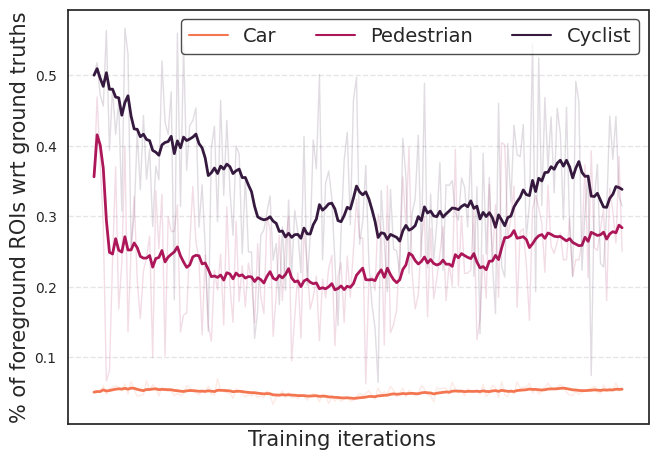

In [56]:
p = sns.color_palette('rocket_r')
def draw_metrics_num_fg(df, fname, tags=None, y_label=None, colors=None):
    f, axes = plt.subplots(1, 1, sharey=True, figsize=(6.5,4.5))
    base_run = "tensorboard"
    classes = ["Car", "Pedestrian", "Cyclist"]
    if colors is None : 
        colors = sns.color_palette('rocket_r', len(classes))
    palette = {'Car': p[1], 'Pedestrian':p[3], 'Cyclist': p[5]}

    classwise_df=pd.DataFrame()
    org_classwise_df = pd.DataFrame()
    for cls_idx, (cls, color) in enumerate(zip(classes, colors)):
        run = base_run + "/" + tags + "/" + cls
        steps = df[df.run == run].step
        values = df[df.run == run].value
        smooth_values = df[df.run == run].ewm(alpha=0.1).mean().value
        # store all classwise IoUs in a single dataframe and plot all at once
        classwise_df[cls] = smooth_values.reset_index(drop=True)
        org_classwise_df[cls] = values.reset_index(drop=True)
            
    sns.lineplot(ax=axes, data=classwise_df, linewidth=2, dashes=False, legend = True, palette=palette)
    sns.lineplot(ax=axes, data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.15)
    # sns.relplot(ax=axes, data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.3, kind='line', ci=95)

    # x/y ticks
    # axes.set_yticks(np.arange(0.05, 0.6, 0.05))
    axes.yaxis.set_tick_params(labelleft=True, labelsize='small')
    axes.xaxis.set_tick_params(labelbottom=False)
    axes.yaxis.grid(True, linestyle='--', alpha=0.5)
    axes.tick_params(pad=2)
    legend = axes.legend(frameon = True, fontsize=14, ncol=3, framealpha = 0.7)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "Training iterations", ha='center', fontsize=15)
    f.text(-0.01, 0.5, y_label, va='center', rotation='vertical', fontsize=15)
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')
    plt.show()

####################################################################
# Plot setting and theme
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

# --------------- Ablation 1 ---------------
exp_id_ab1_ours, exp_name_ab1_ours = "mJAdmSVVSZG3M2lpoigMUg", "best_st_plot_0cf4067"
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")

# --------------- Raw IoUs based on FG ---------------
tag = "rcnn_roi_pl_gt_metrics_cls/pred_fgs"
y_label = '% of foreground ROIs wrt ground truths'
fname = f"pred_fgs.pdf"

draw_metrics_num_fg(df=df_ab1_ours, fname=fname, tags=tag, y_label=y_label)

## (Fig 1) Need of classwise thresholds

In [ ]:
p = sns.color_palette('rocket')
def draw_metrics_fg_ious(dfs, fname, tags=None, tag_names=None, threshs=None, y_label=None, colors=None):
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    base_run = "tensorboard"
    if y_label is None:
        y_label = "ROI IoU wrt. pseudo-labels"
    classes = ["Car", "Pedestrian", "Cyclist"]
    class_thresh = [0.65, 0.45, 0.4]
    if tags is None:
        tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
    if tag_names is None:
        tag_names = ["True Positive ROIs", "False Positive ROIs", "False Negative ROIs"]
    if colors is None : 
        colors = sns.color_palette('rocket', len(classes))
        # palette = {mode: color for mode, color in zip(classes, colors)}
        palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}
    subplot_titles = ['Before', 'After']
    
    for j in range(len(subplot_titles)):
        df = dfs[j]
        classwise_df=pd.DataFrame()
        org_classwise_df = pd.DataFrame()
        for cls_idx, (cls, color) in enumerate(zip(classes, colors)):
            for k, (tag, tname) in enumerate(zip(tags, tag_names)):
                run = base_run + "/" + tag + "/" + cls
                steps = df[df.run == run].step
                print(steps)
                values = df[df.run == run].value
                smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
                
                # store all classwise IoUs in a single dataframe and plot all at once
                classwise_df[cls] = smooth_values.reset_index(drop=True)
                org_classwise_df[cls] = values.reset_index(drop=True)

            # plot threshold lines 
            if j == 0 and cls_idx == 0:
                if threshs is not None:
                    axes[j].axhline(y=threshs[j][cls_idx], linestyle=":", label="$\\tau=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                if threshs is not None:
                    label = "$\\tau_{cls}=thresh$".replace('cls', cls).replace('thresh', str(class_thresh[cls_idx]))
                    axes[j].axhline(y=threshs[j][cls_idx], linestyle=":", label=label, color=palette[cls], alpha=0.9, lw=1.8)
                axes[j].yaxis.set_tick_params(labelleft=True)
        
        # print(len(classwise_df[cls]))
        # plot ious
        if j == 0:
            sns.lineplot(ax=axes[j], data=classwise_df, linewidth=1.5, dashes=False, legend = True, palette=palette)
            sns.lineplot(ax=axes[j], data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.2)
        else:
            sns.lineplot(ax=axes[j], data=classwise_df, linewidth=1.5, dashes=False, legend = True, palette=palette)
            sns.lineplot(ax=axes[j], data=org_classwise_df, linewidth=1, dashes=False, legend = False, palette=palette, alpha = 0.2)
        
        # x/y ticks
        axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # legends
        handles, labels = axes[j].get_legend_handles_labels()

        order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        ncol = 3 if j==1 else 4
        legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

    # common plot labels
    f.text(0.5, -0.01, "$Training\enspaceiterations$", ha='center')
    f.text(-0.01, 0.5, y_label, va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=fname, transparent=False, bbox_inches='tight')
    plt.show()

####################################################################
# Plot setting and theme
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

# --------------- Ablation 1 ---------------
exp_id_ab1_default, exp_name_ab1_default = "dTrxKmgMRQK122Hm1cmaPA", "ablation1_bs8_split_1_1_trial_3_5802d99"
# "o7fRMElwRAKv6boGQb29FQ", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"
exp_id_ab1_ours, exp_name_ab1_ours =  "AfxWpUzaQymD9zpJ9GIGfA", "rev-uc-bg_bs8_split_1_1_trial_1_293070a"
df_ab1_default = pd.read_csv(f"metrics_{exp_name_ab1_default}.csv")
df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")
dfs = [df_ab1_ours, df_ab1_ours]

# --------------- Raw IoUs based on FG ---------------
tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fg"]
y_label = '$FG\enspaceIoU_{ROI, PL}$'
fname = f"fg_roi_iou_wrt_pl_ab1.png"
threshs = np.array([[0.75, 0.75, 0.75], [0.65, 0.45, 0.4]])
draw_metrics_fg_ious(dfs=dfs, fname=fname, threshs=threshs, tags=tags, y_label=y_label)

# Below plots are based on .pkl files as they are plotted based on each iteration

In [64]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="rocket_r", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})

cmap = sns.color_palette("rocket_r", as_cmap=True)
_cmap = sns.color_palette("rocket", as_cmap=True)

df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/best_st_scores.pkl') # best_st_plot_60c84b7
baseline_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl') # iou_metrics_baseline_bs8_split_1_1_trial_1_d16ba20
# This is based on FG+UC+BG with class agnostic local thresholds , it needs a re-run to get the correct class agnostic scores based on UC_FP+BG
# ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_ablation1.pkl') 
ablation1_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/a8_scores.pkl') 
df.keys()



dict_keys(['iou_roi_pl', 'iou_roi_gt', 'pred_scores', 'teacher_pred_scores', 'weights', 'roi_scores', 'pcv_scores', 'num_points_in_roi', 'class_labels', 'iteration'])

## (Fig 1) Need of classwise thresholds

#### Separating TP and FNs

In [ ]:
def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}

    # p = sns.color_palette('rocket')
    q = sns.color_palette("husl", 8)
    print(len(p))
    palette = {'Car': q[5], 'Pedestrian':q[3], 'Cyclist': q[0]}
    # palette = {'Car': p[-2], 'Pedestrian':p[-1], 'Cyclist': p[2]}

    for j in range(2):
        df = dfs[j]
        x = 1
        tp_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
        tp_iou_roi_pl_df['Car'] = np.nan
        tp_iou_roi_pl_df['Pedestrian'] = np.nan
        tp_iou_roi_pl_df['Cyclist'] = np.nan

        fn_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
        fn_iou_roi_pl_df['Car'] = np.nan
        fn_iou_roi_pl_df['Pedestrian'] = np.nan
        fn_iou_roi_pl_df['Cyclist'] = np.nan

        d = {2: 'Pedestrian'}
        for cls_idx, cls_name in d.items():
            cls_mask = torch.Tensor(df['class_labels'])==cls_idx                # filter class
            fg_mask = torch.Tensor(df['iou_roi_gt']) >= fg_thresh[cls_idx-1]    # filter FG ROIs wrt GT
            valid_mask = cls_mask & fg_mask

            aux_df = pd.DataFrame()
            aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])[valid_mask]
            aux_df['iteration'] = torch.Tensor(df['iteration'])[valid_mask]
        
            fg_iou_roi_pl = aux_df.groupby('iteration')['iou_roi_pl'].mean().reset_index()      # get mean FG IoU per iteration
            for idx, _ in tp_iou_roi_pl_df.iterrows():
                if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].size != 0:
                    # Filter TP and FN IoUs
                    if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0] > thresh[j][cls_idx-1]:
                        tp_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]
                    else:
                        fn_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]

            # plot threshold lines 
            if j == 0 and cls_idx == 2:
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\Delta=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                label = "$\\tau^{fg}_{cls}=thresh$".replace('cls', cls_name).replace('thresh', str(thresh[j][cls_idx-1]))
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)
    
        # plot ious
        tp_iou_roi_pl_df = tp_iou_roi_pl_df.drop(['iteration'], axis=1)
        fn_iou_roi_pl_df = fn_iou_roi_pl_df.drop(['iteration'], axis=1)
        ema_alpha = 0.05 if j==0 else 0.05 #0.01 if j==0 else 0.015
        ema_linewidth = 1.8 if j==0 else 1.8
        line_width = 2 if j==0 else 2
        sns.lineplot(ax=axes[j], data=tp_iou_roi_pl_df['Pedestrian'].ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=tp_iou_roi_pl_df['Pedestrian'], linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08, label='TP')

        sns.lineplot(ax=axes[j], data=fn_iou_roi_pl_df['Pedestrian'].ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=fn_iou_roi_pl_df['Pedestrian'], linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08, label='FN')

        # x/y ticks
        axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].tick_params(pad=2)
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # start the 0 of x axis form leftmost part of the plot 
        axes[j].set_xlim(left=0)
        axes[j].set_ylim(bottom=0)
        # remove extra white space at the end of x axis
        axes[j].set_xlim(right=1440/x)
        # # legends
        
        # handles, labels = axes[j].get_legend_handles_labels()
        legend = axes[j].legend(frameon = True, ncol=1, fontsize=9, framealpha = 0.7, loc="lower left")
        # order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        # ncol = 3 if j==1 else 4
        # if j==0:
        #     legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
        #                             frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        # else:
        #     legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
        #                             frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "$Training\enspaceiterations$", ha='center')
    f.text(-0.01, 0.5, '$FG\enspaceIoU_{ROI, PL}$', va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
    plt.show()

#! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [ablation1_df, df]
get_fg_iou_plot(dfs)

In [ ]:
def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}

    # p = sns.color_palette('rocket')
    q = sns.color_palette("husl", 8)
  
    palette = {'Car': q[5], 'Pedestrian':q[3], 'Cyclist': q[0]}
    # palette = {'Car': p[-2], 'Pedestrian':p[-1], 'Cyclist': p[2]}

    for j in range(2):
        df = dfs[j]
        x = 1
        fg_iou_roi_pl_df = pd.DataFrame({'iteration': np.arange(0,1440/x)})
        fg_iou_roi_pl_df['Car'] = np.nan
        fg_iou_roi_pl_df['Pedestrian'] = np.nan
        fg_iou_roi_pl_df['Cyclist'] = np.nan

        for cls_idx, cls_name in num_to_class.items():
            cls_mask = torch.Tensor(df['class_labels'])==cls_idx
            fg_mask = torch.Tensor(df['iou_roi_gt']) >= fg_thresh[cls_idx-1]
            valid_mask = cls_mask & fg_mask

            aux_df = pd.DataFrame()
            aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])[valid_mask]
            aux_df['iteration'] = torch.Tensor(df['iteration'])[valid_mask]
        
            fg_iou_roi_pl = aux_df.groupby('iteration')['iou_roi_pl'].mean().reset_index()
            for idx, _ in fg_iou_roi_pl_df.iterrows():
                if fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].size != 0:
                    fg_iou_roi_pl_df.at[idx, cls_name] = fg_iou_roi_pl['iou_roi_pl'][fg_iou_roi_pl['iteration']==idx].values[0]

            # plot threshold lines 
            if j == 0 and cls_idx == 1:
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\tau^{fg}=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                label = "$\\tau^{fg}_{cls}=thresh$".replace('cls', cls_name.lower()[:3]).replace('thresh', str(thresh[j][cls_idx-1]))
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)

        # plot ious
        fg_iou_roi_pl_df = fg_iou_roi_pl_df.drop(['iteration'], axis=1)
        ema_alpha = 0.01 if j==0 else 0.015
        ema_linewidth = 1.8 if j==0 else 1.8
        line_width = 2 if j==0 else 2
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df.ewm(alpha=ema_alpha).mean(), linewidth=ema_linewidth, dashes=False, legend = True, palette=palette)
        sns.lineplot(ax=axes[j], data=fg_iou_roi_pl_df, linewidth=line_width, dashes=False, legend = False, palette=palette, alpha = 0.08)

        # x/y ticks
        # axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].tick_params(pad=2)
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # start the 0 of x axis form leftmost part of the plot 
        axes[j].set_xlim(left=0)
        axes[j].set_ylim(bottom=0)
        # remove extra white space at the end of x axis
        axes[j].set_xlim(right=1440/x)
        # legends
        
        handles, labels = axes[j].get_legend_handles_labels()

        order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        ncol = 3 if j==1 else 4
        if j==0:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        else:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "Training iterations", ha='center', fontsize=14)
    f.text(-0.01, 0.5, '$\mathrm{u}_{\mathrm{i}}$ which are foreground wrt GT', va='center', rotation='vertical', fontsize=14)
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
    plt.show()

#! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [ablation1_df, df]
get_fg_iou_plot(dfs)

In [20]:
sns.color_palette('rocket_r')

[(0.96516917, 0.70776351, 0.5606593),
 (0.95381595, 0.46373781, 0.31769923),
 (0.8833417, 0.19830556, 0.26014181),
 (0.67824099, 0.09192342, 0.3504148),
 (0.43860848, 0.12177004, 0.34119475),
 (0.20973515, 0.09747934, 0.24238489)]

6
['Car', 'Pedestrian', 'Cyclist', '$\\tau^{fg}=0.75$']
['Car', 'Pedestrian', 'Cyclist', '$\\tau^{fg}_{car}=0.65$', '$\\tau^{fg}_{ped}=0.45$', '$\\tau^{fg}_{cyc}=0.4$']


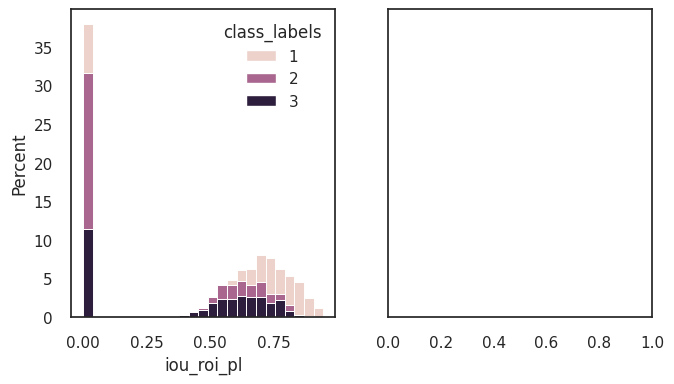

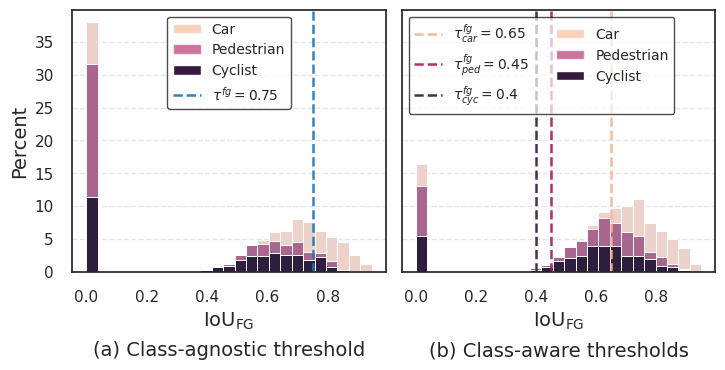

In [76]:
from matplotlib.patches import Rectangle
def get_equal_rows(df, num_rows):
    df = df.sort_values(by=['iteration'], ascending=False)
    df = df.reset_index(drop=True)
    equal_rows = []
    for cls in df['class_labels'].unique():
        equal_rows.append(df[df['class_labels']==cls][:num_rows])
    return pd.concat(equal_rows)

def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", rc={
                                    'xtick.bottom': False,
                                    'ytick.left': False,
                                    })      
    f, axes = plt.subplots(1, 2, sharey=True, figsize=(7.5,4))
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    p = sns.color_palette('rocket_r')
    print(len(p))
    palette = {'Car': p[0], 'Pedestrian':p[3], 'Cyclist': p[5]}
    # show me the above palette in the output



    for j in range(2):
        df = dfs[j]
        mask = (df['class_labels'] == 1) & (df['iou_roi_gt'] < fg_thresh[0]) | \
                (df['class_labels'] == 2) & (df['iou_roi_gt'] < fg_thresh[1]) | \
                (df['class_labels'] == 3) & (df['iou_roi_gt'] < fg_thresh[2])
        df = df[~mask]
        df = get_equal_rows(df, 500)

        sns.histplot(ax=axes[j], data=df, x="iou_roi_pl", hue="class_labels", fill=True, kde=False, multiple="stack", stat='percent', legend=True, bins=25, color=palette, alpha=1)

        if j==0:
            axes[j].axvline(x=0.75, linestyle="--", label="$\\tau^{fg}=0.75$", color=sns.color_palette("tab10")[0], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)
        else:
            axes[j].axvline(x=0.65, linestyle="--", label="$\\tau^{fg}_{car}=0.65$", color=palette['Car'], alpha=0.9, lw=1.8)
            axes[j].axvline(x=0.45, linestyle="--", label="$\\tau^{fg}_{ped}=0.45$", color=palette['Pedestrian'], alpha=0.9, lw=1.8)
            axes[j].axvline(x=0.4, linestyle="--", label="$\\tau^{fg}_{cyc}=0.4$", color=palette['Cyclist'], alpha=0.9, lw=1.8)
        
        axes[j].xaxis.set_tick_params(labelbottom=True)
        axes[j].set_xlabel('$\mathrm{IoU}_{\mathrm{FG}}$', fontsize=14)
        axes[j].set_ylabel('Percent', fontsize=14)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)

        handles1 = [Rectangle((0,0),1,1,color=palette['Car'],ec=None, alpha=0.6),
                    Rectangle((0,0),1,1,color=palette['Pedestrian'],ec=None, alpha=0.6),
                    Rectangle((0,0),1,1,color=palette['Cyclist'],ec=None, alpha=1)] 
        labels1= ["Car","Pedestrian", "Cyclist"]
        plt.legend(handles1, labels1)

        handles2, labels2 = axes[j].get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        print(labels)
        ncol = 1 if j==0 else 2
        order = [3,4,5,0,1,2] if j == 1 else [0,1,2,3]
        loc = "best" if j == 0 else "upper left"
        legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], frameon = True, ncol=ncol, fontsize=10, framealpha = 0.7, loc=loc)

        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
        # add subplot caption at bottom center of each plot
        axes[j].text(0.5, -0.30, f"({chr(97+j)}) {['Class-agnostic threshold', 'Class-aware thresholds'][j]}", ha='center', va='center', transform=axes[j].transAxes, fontsize=14)
    
    f.tight_layout()
    f.subplots_adjust(wspace=0.05, hspace=0.2)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.pdf", transparent=False, bbox_inches='tight')
    plt.show()


_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in df.items() ])) 
_ablation1_df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in ablation1_df.items() ])) 

# #! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [_ablation1_df, _df]
get_fg_iou_plot(dfs)

In [ ]:
def get_fg_iou_plot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,5))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
    
    p = sns.color_palette('rocket')
    colors = sns.color_palette('rocket', len(thresh))
    palette = {'Car': p[2], 'Pedestrian':p[0], 'Cyclist': p[-2]}
    palette_ = {1: p[2], 2:p[0], 3: p[-2]}
    # roi_ious_pl_df = pd.DataFrame()
    df = pd.DataFrame()
    fg_iou_roi_pl_df = pd.DataFrame()
    window_size = 64
    for j in range(len(dfs)):
        df = dfs[j]
        mask = (df['class_labels'] == 1) & (df['iou_roi_gt'] < fg_thresh[0]) | \
                (df['class_labels'] == 2) & (df['iou_roi_gt'] < fg_thresh[1]) | \
                (df['class_labels'] == 3) & (df['iou_roi_gt'] < fg_thresh[2])
        df = df[~mask]
        df['new_iteration'] = df['iteration'] // window_size

        for cls_idx, cls_name in num_to_class.items():
            # plot threshold lines 
            if j == 0 and cls_idx == 1:
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label="$\\tau^{fg}=0.75$", color='black', alpha=0.9, lw=1.8)
            if j == 1:
                label = "$\\tau^{fg}_{cls}=thresh$".replace('cls', cls_name[:3]).replace('thresh', str(thresh[j][cls_idx-1]))
                axes[j].axhline(y=thresh[j][cls_idx-1], linestyle=":", label=label, color=palette[cls_name], alpha=0.9, lw=1.8)
            axes[j].yaxis.set_tick_params(labelleft=True)

        sns.relplot(ax=axes[j], data=df, x='new_iteration', y='iou_roi_pl', kind='line', hue='class_labels', palette=palette_, legend=True)

        # fetch labels from above plot
        handles_1, labels_1 = plt.gca().get_legend_handles_labels()
       
        # axes[j].legend()
        # x/y ticks
        # axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
        axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
        axes[j].xaxis.set_tick_params(labelbottom=False)
        axes[j].yaxis.grid(True, linestyle='--', alpha=0.5)
        # legends
        handles_2, labels_2 = axes[j].get_legend_handles_labels()

        handles = handles_1 + handles_2
        labels = labels_1 + labels_2
        print(labels)
        order = [0,3,1,4,2,5] if j == 1 else [0,1,2,3]
        ncol = 3 if j==1 else 4
        if j==0:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        else:
            legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
                                    frameon = True, ncol=ncol, fontsize=9, framealpha = 0.7, loc="lower left")
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    
    # common plot labels
    f.text(0.5, -0.01, "Training iterations", ha='center')
    f.text(-0.01, 0.5, '$u_{i}$ which are foreground w.r.t ground truth', va='center', rotation='vertical')
    f.tight_layout()
    f.subplots_adjust(wspace=0.02, hspace=0.05)
    f.savefig(fname=f"fg_roi_iou_wrt_pl_ab1.png", transparent=False, bbox_inches='tight')
    plt.show()

baseline_df = pd.DataFrame(baseline_df)
df = pd.DataFrame(df)    
#! TODO : change baseline dataframe to ablation 1 dataframe !!
dfs = [df, df]
get_fg_iou_plot(dfs)

##  (Fig 4) % of FG IoUs crossing local thresh using Barplot

In [ ]:
def get_fg_iou_barplot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,7))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
    
    combined_df = pd.DataFrame()
    for j in range(2):
        experiment = 'Class-agnostic local thresholds' if j==0 else 'Class-wise local thresholds'
        df = dfs[j]
        
        aux_df = pd.DataFrame()
        aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])
        aux_df['iou_roi_gt'] = torch.Tensor(df['iou_roi_gt'])
        aux_df['iteration'] = torch.Tensor(df['iteration'])
        aux_df['class_labels'] = torch.Tensor(df['class_labels'])

        # Extract TP+FN for recall
        recall_condition1 = (aux_df['class_labels']==1) & (aux_df['iou_roi_gt']<0.7)
        recall_condition2 = (aux_df['class_labels']==2) & (aux_df['iou_roi_gt']<0.5)
        recall_condition3 = (aux_df['class_labels']==3) & (aux_df['iou_roi_gt']<0.5)
        recall_df = aux_df.drop(aux_df[recall_condition1 | recall_condition2 | recall_condition3].index)

        # Extract TP+FP for precision
        precision_condition1 = (aux_df['class_labels']==1) & (aux_df['iou_roi_pl']<0.65)
        precision_condition2 = (aux_df['class_labels']==2) & (aux_df['iou_roi_pl']<0.45)
        precision_condition3 = (aux_df['class_labels']==3) & (aux_df['iou_roi_pl']<0.4)
        precision_df = aux_df.drop(aux_df[precision_condition1 | precision_condition2 | precision_condition3].index)

        recall_percent = {}
        precision_percent = {}
        for cls_idx, cls_name in enumerate(num_to_class.values()):
            recall_classwise_df = pd.DataFrame()
            precision_classwise_df = pd.DataFrame()

            recall_classwise_df = recall_df[recall_df['class_labels']==(cls_idx+1)]
            precision_classwise_df = precision_df[precision_df['class_labels']==(cls_idx+1)]

            recall_percent[cls_name] = len(recall_classwise_df[recall_classwise_df['iou_roi_pl'] > thresh[j][cls_idx]]) / len(recall_classwise_df)
            precision_percent[cls_name] = len(precision_classwise_df[precision_classwise_df['iou_roi_gt'] > fg_thresh[cls_idx]]) / len(precision_classwise_df)

            combined_df = combined_df.append({'Experiment': experiment, 'class_labels': cls_name, \
                                            'recall_percent': recall_percent[cls_name], 'precision_percent': precision_percent[cls_name]}, ignore_index=True)
    
    # plt precision_percent and recall_percent in a single plot
    sns.barplot(ax=axes[0], data=combined_df, x="precision_percent", y="class_labels", hue="Experiment", palette="rocket_r", width=0.25, orient="h")

    sns.barplot(ax=axes[0], data=combined_df, x="recall_percent", y="class_labels", hue="Experiment", palette="rocket_r", width=0.25, orient="h")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("")
    axes[0].set_title("Recall of targets for unlabeled RCNN classification loss")
    patches = axes[0].patches
    for i in range(len(patches)):
        x = patches[i].get_width() + 0.04
        y = patches[i].get_y() + patches[i].get_height()/2 + 0.05
        axes[0].annotate('{:.1f}%'.format(list(combined_df['recall_percent']*100)[i]), (x, y), ha='center', color="black", size=9)
    
    axes[0].tick_params(pad=2)
    axes[0].set_xticks(np.arange(0, 1.1, 0.1))
    axes[0].set_xticklabels(np.arange(0, 110, 10))
    axes[0].yaxis.set_tick_params(labelleft=True, labelsize='small')
    axes[0].xaxis.set_tick_params(labelbottom=True, labelsize='small')
    axes[0].xaxis.grid(True, linestyle='--', alpha=0.5)
    legend = axes[0].legend(frameon = True, ncol=1, fontsize=8.5, framealpha = 0.5, loc='best', bbox_to_anchor=(0.99, 0.8))
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')


    sns.barplot(ax=axes[1], data=combined_df, x="precision_percent", y="class_labels", hue="Experiment", palette="rocket_r", width=0.25, orient="h")
    axes[1].set_title("Precision of targets for unlabeled RCNN classification loss")
    axes[1].set_xlabel("")
    axes[1].set_ylabel("")
    patches = axes[1].patches
    for i in range(len(patches)):
        x = patches[i].get_width() + 0.04
        y = patches[i].get_y() + patches[i].get_height()/2 + 0.05
        axes[1].annotate('{:.1f}%'.format(list(combined_df['precision_percent']*100)[i]), (x, y), ha='center', color="black", size=9)
    axes[1].tick_params(pad=2)
    axes[1].set_xticks(np.arange(0, 1.1, 0.1))
    axes[1].set_xticklabels(np.arange(0, 110, 10))
    axes[1].yaxis.set_tick_params(labelleft=True, labelsize='small')
    axes[1].xaxis.set_tick_params(labelbottom=True, labelsize='small')
    axes[1].xaxis.grid(True, linestyle='--', alpha=0.5)
    legend = axes[1].legend(frameon = True, ncol=1, fontsize=8.5, framealpha = 0.5, loc='best', bbox_to_anchor=(0.99, 0.8))
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    f.subplots_adjust(hspace=0.25)
    plt.show()
    
    f.tight_layout()
    f.savefig(fname=f"cls_target_recall.pdf", transparent=False, bbox_inches='tight')

dfs = [ablation1_df, df]
get_fg_iou_barplot(dfs)


In [ ]:
def get_fg_iou_barplot(dfs):
    sns.set_theme(style="ticks", palette="rocket_r", rc={
                                                        'xtick.bottom': False,
                                                        'ytick.left': False,
                                                        })      
    f, axes = plt.subplots(2, 1, sharey=True, figsize=(6.5,7))
    thresh = [[0.75,0.75,0.75], [0.65,0.45,0.4]] # local thresholds 
    fg_thresh = [0.7, 0.5, 0.5] # for getting FG mask 
    num_to_class = {1:'Car', 2:'Pedestrian', 3:'Cyclist'}
    
    combined_df = pd.DataFrame()
    for j in range(2):
        experiment = 'Class-agnostic local thresholds' if j==0 else 'Class-wise local thresholds'
        df = dfs[j]
        
        aux_df = pd.DataFrame()
        aux_df['iou_roi_pl'] = torch.Tensor(df['iou_roi_pl'])
        aux_df['iou_roi_gt'] = torch.Tensor(df['iou_roi_gt'])
        aux_df['iteration'] = torch.Tensor(df['iteration'])
        aux_df['class_labels'] = torch.Tensor(df['class_labels'])

        recall_condition1 = (aux_df['class_labels']==1) & (aux_df['iou_roi_gt']<0.7)
        recall_condition2 = (aux_df['class_labels']==2) & (aux_df['iou_roi_gt']<0.5)
        recall_condition3 = (aux_df['class_labels']==3) & (aux_df['iou_roi_gt']<0.5)
        recall_df = aux_df.drop(aux_df[recall_condition1 | recall_condition2 | recall_condition3].index)


        precision_condition1 = (aux_df['class_labels']==1) & (aux_df['iou_roi_pl']<0.65)
        precision_condition2 = (aux_df['class_labels']==2) & (aux_df['iou_roi_pl']<0.45)
        precision_condition3 = (aux_df['class_labels']==3) & (aux_df['iou_roi_pl']<0.4)
        precision_df = aux_df.drop(aux_df[precision_condition1 | precision_condition2 | precision_condition3].index)
        
        # create loop over maximum value of 'iteration'
        for i in range(0, int(max(recall_df['iteration']))):
            # check which rows has 'iteration' value equal to i
            recall_df_i = recall_df[recall_df['iteration']==i]
            precision_df_i = precision_df[precision_df['iteration']==i]
            
            # find how many rows in recall_df_i have 'iou_roi_pl' > thresh[j][cls_idx] where cls_idx is the class index corresponding to the class label
            if len(recall_df_i) > 0:
                # create a new column 'thresh' to assign thresholds to each row based on class_labels
                recall_df_i['thresh'] = recall_df_i['class_labels'].apply(lambda x: thresh[j][int(x)-1]) if j==1 else 0.75
                recall_df_i['recall_percent'] = len(recall_df_i[recall_df_i['iou_roi_pl'] > recall_df_i['thresh']]) / len(recall_df_i)
            # else set recall_percent to nan
            else:
                recall_df_i['recall_percent'] = np.nan
                
            # find how many rows in precision_df_i have 'iou_roi_gt' > fg_thresh[cls_idx]
            if len(precision_df_i) > 0:
                precision_df_i['thresh'] = precision_df_i['class_labels'].apply(lambda x: fg_thresh[int(x)-1])
                precision_df_i['precision_percent'] = len(precision_df_i[precision_df_i['iou_roi_gt'] > precision_df_i['thresh']]) / len(precision_df_i)
            # else set precision_percent to nan
            else:
                precision_df_i['precision_percent'] = np.nan
            # append recall_df_i and precision_df_i to combined_df
            combined_df = combined_df.append(recall_df_i)
            combined_df = combined_df.append(precision_df_i)
        print(combined_df)
        # plot lineplot for recall and precision
        sns.lineplot(x='iteration', y='recall_percent', hue='class_labels', data=combined_df, ax=axes[0], legend=False)
        sns.lineplot(x='iteration', y='precision_percent', hue='class_labels', data=combined_df, ax=axes[1], legend=False)


            








        # recall_percent = {}
        # precision_percent = {}
        
        # for cls_idx, cls_name in enumerate(num_to_class.values()):
        #     recall_classwise_df = pd.DataFrame()
        #     precision_classwise_df = pd.DataFrame()

        #     recall_classwise_df = recall_df[recall_df['class_labels']==(cls_idx+1)]
        #     precision_classwise_df = precision_df[precision_df['class_labels']==(cls_idx+1)]

        #     recall_percent[cls_name] = len(recall_classwise_df[recall_classwise_df['iou_roi_pl'] > thresh[j][cls_idx]]) / len(recall_classwise_df)
        #     precision_percent[cls_name] = len(precision_classwise_df[precision_classwise_df['iou_roi_gt'] > fg_thresh[cls_idx]]) / len(precision_classwise_df)

        #     combined_df = combined_df.append({'Experiment': experiment, 'class_labels': cls_name, \
        #                                     'recall_percent': recall_percent[cls_name], 'precision_percent': precision_percent[cls_name]}, ignore_index=True)

    # sns.barplot(ax=axes[0], data=combined_df, x="recall_percent", y="class_labels", hue="Experiment", palette="rocket_r", width=0.25, orient="h")
    # axes[0].set_xlabel("")
    # axes[0].set_ylabel("")
    # axes[0].set_title("Recall of targets for unlabeled RCNN classification loss")
    # patches = axes[0].patches
    # for i in range(len(patches)):
    #     x = patches[i].get_width() + 0.04
    #     y = patches[i].get_y() + patches[i].get_height()/2 + 0.05
    #     axes[0].annotate('{:.1f}%'.format(list(combined_df['recall_percent']*100)[i]), (x, y), ha='center', color="black", size=9)
    
    # axes[0].tick_params(pad=2)
    # axes[0].set_xticks(np.arange(0, 1.1, 0.1))
    # axes[0].set_xticklabels(np.arange(0, 110, 10))
    # axes[0].yaxis.set_tick_params(labelleft=True, labelsize='small')
    # axes[0].xaxis.set_tick_params(labelbottom=True, labelsize='small')
    # axes[0].xaxis.grid(True, linestyle='--', alpha=0.5)
    # legend = axes[0].legend(frameon = True, ncol=1, fontsize=8.5, framealpha = 0.5, loc='best', bbox_to_anchor=(0.99, 0.8))
    # frame = legend.get_frame()
    # frame.set_color('white')
    # frame.set_edgecolor('black')


    # sns.barplot(ax=axes[1], data=combined_df, x="precision_percent", y="class_labels", hue="Experiment", palette="rocket_r", width=0.25, orient="h")
    # axes[1].set_title("Precision of targets for unlabeled RCNN classification loss")
    # axes[1].set_xlabel("")
    # axes[1].set_ylabel("")
    # patches = axes[1].patches
    # for i in range(len(patches)):
    #     x = patches[i].get_width() + 0.04
    #     y = patches[i].get_y() + patches[i].get_height()/2 + 0.05
    #     axes[1].annotate('{:.1f}%'.format(list(combined_df['precision_percent']*100)[i]), (x, y), ha='center', color="black", size=9)
    # axes[1].tick_params(pad=2)
    # axes[1].set_xticks(np.arange(0, 1.1, 0.1))
    # axes[1].set_xticklabels(np.arange(0, 110, 10))
    # axes[1].yaxis.set_tick_params(labelleft=True, labelsize='small')
    # axes[1].xaxis.set_tick_params(labelbottom=True, labelsize='small')
    # axes[1].xaxis.grid(True, linestyle='--', alpha=0.5)
    # legend = axes[1].legend(frameon = True, ncol=1, fontsize=8.5, framealpha = 0.5, loc='best', bbox_to_anchor=(0.99, 0.8))
    # frame = legend.get_frame()
    # frame.set_color('white')
    # frame.set_edgecolor('black')
    # f.subplots_adjust(hspace=0.25)
    plt.show()
    
    f.tight_layout()
    f.savefig(fname=f"cls_target_recall.pdf", transparent=False, bbox_inches='tight')

dfs = [df, df]
get_fg_iou_barplot(dfs)


## (Fig 5) Weights scatterplot 

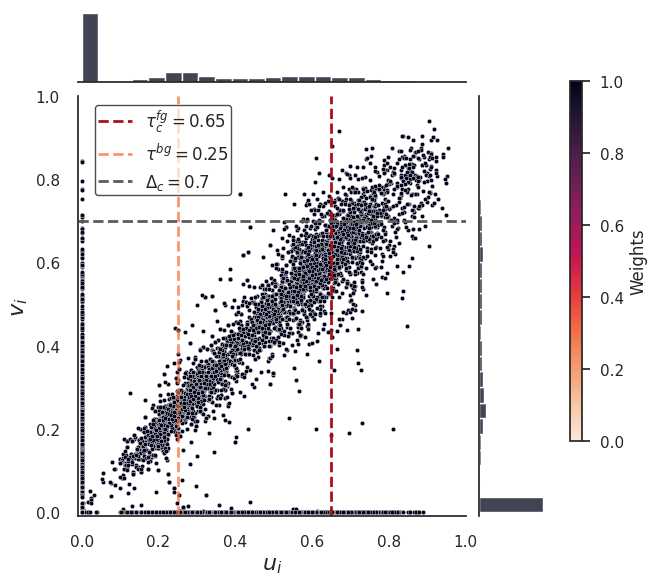

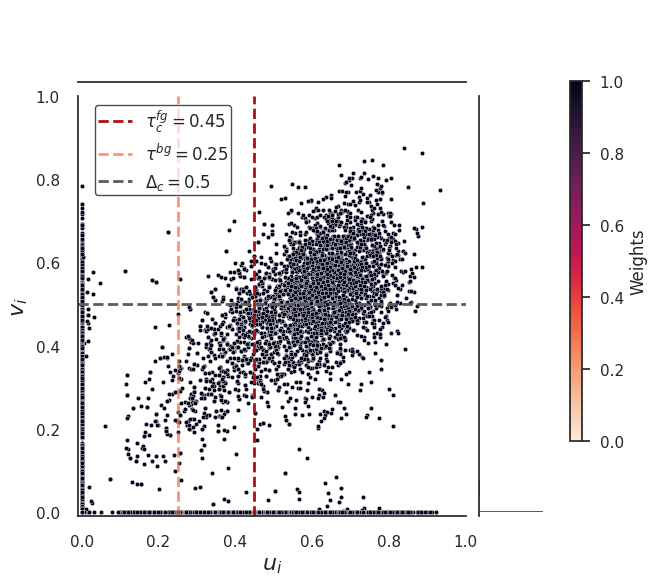

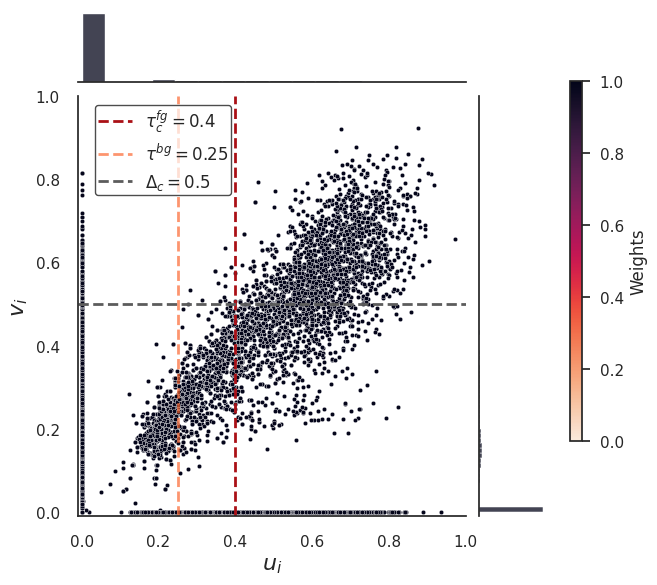

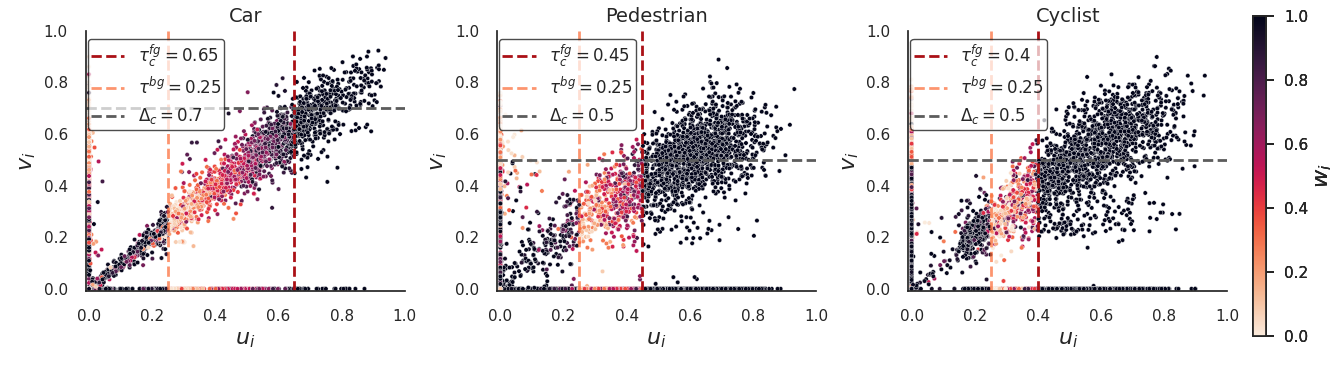

In [89]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec, class_name, disable_marginal_plot=True):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        self.disable_marginal_plot = disable_marginal_plot
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid(class_name)
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self, class_name):
        """ Move Jointgrid """
        self.sg.ax_joint.set_title(class_name, fontsize=14)
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        # disable marginal plots 
        if not self.disable_marginal_plot:
            self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
            self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])
        
        left_pos = 0.97 if self.disable_marginal_plot else 1
        # Make space for the colorbar
        self.fig.subplots_adjust(right=1.2)
        # Define a new Axes where the colorbar will go
        cax = self.fig.add_axes([left_pos, 0.1, .01, 0.80])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        self.fig.colorbar(points, cax=cax).set_label("$w_{i}$", fontsize=16)

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())


def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint", epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = 1439-(24*epoch_num)

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask #& ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5)
        plt.show()
    else:
        if fig_title=='Before':
            color = _cmap(1)
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", color=color, xlim=-0.01, ylim=-0.01, legend=True, palette="rocket_r", s=10)
        else:
            g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", hue='weights', xlim=-0.01, ylim=-0.01, legend=False, palette="rocket_r", s=10)
        g.set_axis_labels('$u_{i}$', '$v_{i}$', fontsize=16)
    
        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau^{fg}_{c}=var$".replace('var', str(pl_thresh['FG'][class_name])), lw=2)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau^{bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-2], label="$\\Delta_{c}=var$".replace('var', str(gt_thresh['FG'][class_name])), lw=2)
        # plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)

        legend = plt.legend(bbox_to_anchor=(0.22, 1), frameon=True, fontsize=12, loc='upper center', borderpad=0.2, framealpha = 0.7) #'lower left'
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

        # Make space for the colorbar
        g.fig.subplots_adjust(right=.92)
        # Define a new Axes where the colorbar will go
        cax = g.fig.add_axes([.96, .25, .02, .6])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap=cmap)
        # Draw the colorbar
        g.fig.colorbar(points, cax=cax).set_label("Weights")
        # plt.show()
    return g

car_plot_before = get_joint_plot(baseline_df, 'Car', "Before", epoch_num=0.50)
car_plot_after = get_joint_plot(df, 'Car', "After", epoch_num=0.50)

ped_plot_before = get_joint_plot(baseline_df, 'Pedestrian', "Before", epoch_num=14)
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After", epoch_num=14)

cyc_plot_before = get_joint_plot(baseline_df, 'Cyclist', "Before", epoch_num=24)
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After", epoch_num=24)

fig = plt.figure(figsize=(13,4))
gs = gridspec.GridSpec(1, 3)

# disable the marginal plots using this flag
disable_marginal_plot = True
#before
# mg0 = SeabornFig2Grid(car_plot_before, fig, gs[0], disable_marginal_plot)
# mg1 = SeabornFig2Grid(ped_plot_before, fig, gs[1], disable_marginal_plot)
# mg2 = SeabornFig2Grid(cyc_plot_before, fig, gs[2], disable_marginal_plot)
#after
mg3 = SeabornFig2Grid(car_plot_after, fig, gs[0], 'Car', disable_marginal_plot)
mg4 = SeabornFig2Grid(ped_plot_after, fig, gs[1], 'Pedestrian', disable_marginal_plot)
mg5 = SeabornFig2Grid(cyc_plot_after, fig, gs[2], 'Cyclist', disable_marginal_plot)

gs.tight_layout(fig)
fig.savefig(fname="ious_weights.pdf", transparent=False, bbox_inches='tight')
plt.show()


## (Fig 3) KDE Plot for IoUs wrt PL and GT for all the samples 
#### (over last 10 epochs)

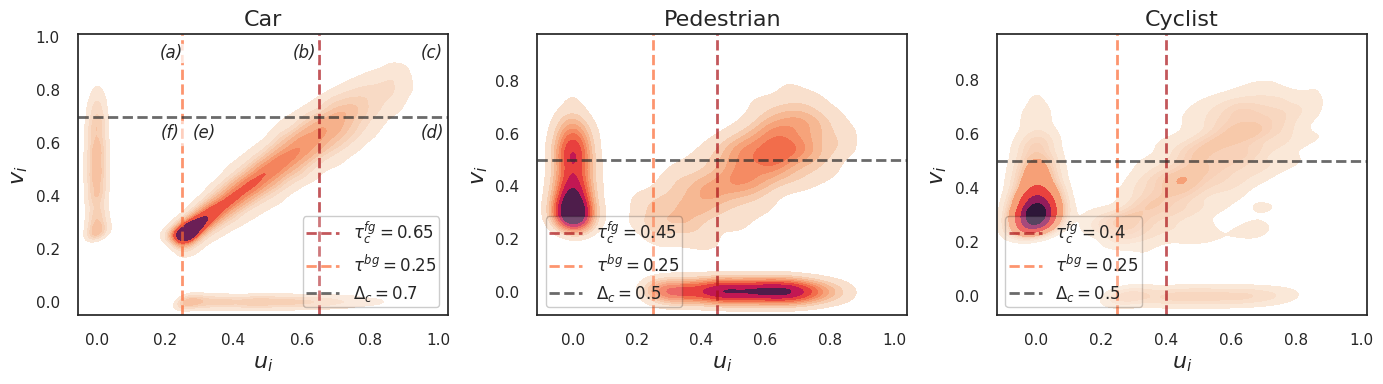

In [91]:
def get_kde_plot(df, class_name, ax, epoch_num=10):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    start_iter = (1439-(24*epoch_num)) if epoch_num != None else 0
#     start_iter = (24*epoch_num) if epoch_num != None else 0

    epoch_mask = torch.Tensor(df['iteration']).int() > start_iter 
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < gt_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask
 
    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})
# add title to kde plot
    ax.set_title(class_name, fontsize=16)
    sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap=cmap, palette="rocket_r", shade=True, bw_adjust=.5, ax=ax)

    ax.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color=sns.color_palette("Reds")[-1], label="$\\tau^{fg}_{c}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    ax.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color=sns.color_palette('YlOrRd')[-3], label="$\\tau^{bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2)
    ax.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color=sns.color_palette("Greys")[-1], label="$\\Delta_{c}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2)
    # ax.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2)
    ax.set_xlabel('$u_{i}$', fontsize=16)
    ax.set_ylabel('$v_{i}$', fontsize=16)
    if class_name=='Car':
        legend_loc = "lower right"
    else:
        legend_loc = "lower left"
    legend = ax.legend(frameon=True, fontsize=12, loc=legend_loc, borderpad=0.2, framealpha = 0.2)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    
    if class_name=='Car':
        edge_color = 'white'
        ax.text(0.184, 0.92, '(a)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.575, 0.92, '(b)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.95, 0.92, '(c)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.95, 0.62, '(d)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 0, 'edgecolor': edge_color})
        ax.text(0.28, 0.62, '(e)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})
        ax.text(0.188, 0.62, '(f)', style='italic', fontsize=12, #ha='center', 
                bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 2, 'edgecolor': edge_color})


fig, axes = plt.subplots(1, 3, figsize=(14, 4))

get_kde_plot(df, 'Car', epoch_num=10, ax=axes[0]) # 0.5
get_kde_plot(df, 'Pedestrian', epoch_num=10, ax=axes[1]) #14
get_kde_plot(df, 'Cyclist', epoch_num=10, ax=axes[2]) #24

fig.tight_layout()
fig.savefig(fname="ious_kde.pdf", transparent=False, bbox_inches='tight')
plt.show()